In [16]:
import numpy as np
import pandas as pd
import geopandas as gpd

import sys
import os

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

In [17]:
target_cd = 'c:\\Users\\jarem\\OneDrive - London School of Economics\\YEAR 2\\1. Policy paper\\policy-paper-repo'
os.chdir(target_cd)
print(f"Current working directory path set to: {os.getcwd()}")

Current working directory path set to: c:\Users\jarem\OneDrive - London School of Economics\YEAR 2\1. Policy paper\policy-paper-repo


### Read in data

Economic vars

In [18]:
df_nuts3 = pd.read_csv('data/inputs/BDL_pol/Ekonomia regionalna/RACH_3501_CREL_20260125142709_subregions.csv', 
                 sep =";", decimal = ",")

In [19]:
df_nuts2 = pd.read_csv('data/inputs/BDL_pol/Ekonomia regionalna/RACH_3499_CREL_20260125185814_NUTS2.csv', 
                 sep =";", decimal = ",")

In [20]:
for df in [df_nuts2, df_nuts3]:    
    df.rename(columns={
        "Kod" : "CODE_PL",
        "Nazwa" : "NUTS_NAME",
        "Rok" : "YEAR",
        "Wartosc" : "VALUE",
        "Wskaźniki" : "INDICATOR",
        "Jednostka miary" : "UNIT",
        "Atrybut" : "ATTRIBUTE"
    }, inplace = True)
    df.drop(columns=["Unnamed: 7","ATTRIBUTE"], inplace = True)

    df['NUTS_NAME'] = df['NUTS_NAME'].str.replace('PODREGION', '', regex=False).str.strip()

    df = df[df['YEAR']<2024]
    
df_nuts2 = df_nuts2[df_nuts2["NUTS_NAME"]!="POLSKA"]
df_nuts2['NUTS_NAME'] = df_nuts2['NUTS_NAME'].str.strip().str.upper()



Geometries

In [21]:
geom = gpd.read_file(f'data/inputs/shapefiles/NUTS_RG_10M_2024_3035.gpkg')

#get and store nuts2 geoms
# #filter only to poland and NUTS2 level, then drop these cols
geom_nuts2 = geom.copy()
geom_nuts2 = geom_nuts2[geom_nuts2['CNTR_CODE'] == 'PL']
geom_nuts2 = geom_nuts2[geom_nuts2['LEVL_CODE'] == 2]
geom_nuts2.drop(columns = ['LEVL_CODE', 'CNTR_CODE'], inplace = True)

geom_nuts2['NUTS_NAME'] = geom_nuts2['NUTS_NAME'].str.strip().str.upper()

# Dissolve the two Mazowieckie subregions into one
mask = geom_nuts2['NUTS_NAME'].isin(['WARSZAWSKI STOLECZNY', 'MAZOWIECKI REGIONALNY'])
mazowieckie_geom = geom_nuts2[mask].copy()
mazowieckie_geom['dummy'] = 1
mazowieckie_geom = mazowieckie_geom.dissolve(by='dummy').geometry.values[0]

# Remove the original two subregions
geom_nuts2 = geom_nuts2[~mask]

# Add the new combined row
mazowieckie_row = gpd.GeoDataFrame({
    'NUTS_NAME': ['MAZOWIECKIE'],
    'geometry': [mazowieckie_geom]
}, geometry='geometry', crs=geom_nuts2.crs)

geom_nuts2 = pd.concat([geom_nuts2, mazowieckie_row], ignore_index=True)

# Keep only the ones present in df_nuts2
df_nuts2['NUTS_NAME'] = df_nuts2['NUTS_NAME'].replace({
    'WARSZAWSKI STOŁECZNY': 'MAZOWIECKIE',
    'MAZOWIECKI REGIONALNY': 'MAZOWIECKIE'
})


print(df_nuts2['NUTS_NAME'].unique())
print(geom_nuts2['NUTS_NAME'].unique())

['DOLNOŚLĄSKIE' 'KUJAWSKO-POMORSKIE' 'LUBELSKIE' 'LUBUSKIE' 'ŁÓDZKIE'
 'MAŁOPOLSKIE' 'MAZOWIECKIE' 'OPOLSKIE' 'PODKARPACKIE' 'PODLASKIE'
 'POMORSKIE' 'ŚLĄSKIE' 'ŚWIĘTOKRZYSKIE' 'WARMIŃSKO-MAZURSKIE'
 'WIELKOPOLSKIE' 'ZACHODNIOPOMORSKIE']
['MAŁOPOLSKIE' 'ŚLĄSKIE' 'WIELKOPOLSKIE' 'ZACHODNIOPOMORSKIE' 'LUBUSKIE'
 'DOLNOŚLĄSKIE' 'OPOLSKIE' 'KUJAWSKO-POMORSKIE' 'WARMIŃSKO-MAZURSKIE'
 'POMORSKIE' 'ŁÓDZKIE' 'ŚWIĘTOKRZYSKIE' 'LUBELSKIE' 'PODKARPACKIE'
 'PODLASKIE' 'WARSZAWSKI STOŁECZNY' 'MAZOWIECKIE']


In [22]:
#filter only to poland and NUTS3 level, then drop these cols
geom = gpd.read_file(f'data/inputs/shapefiles/NUTS_RG_10M_2024_3035.gpkg')

geom_nuts3 = geom.copy()
geom_nuts3 = geom_nuts3[geom_nuts3['CNTR_CODE'] == 'PL']
geom_nuts3 = geom_nuts3[geom_nuts3['LEVL_CODE'] == 3]
geom_nuts3.drop(columns = ['LEVL_CODE', 'CNTR_CODE'], inplace = True)

geom_nuts3['NUTS_NAME'] = geom_nuts3['NUTS_NAME'].str.strip().str.upper()

In [23]:
geom_nuts3.NUTS_ID.nunique(), df_nuts3.CODE_PL.nunique(), geom_nuts2.NUTS_ID.nunique(), df_nuts2.CODE_PL.nunique()


(73, 73, 16, 16)

In [29]:
merged = pd.merge(df_nuts3, geom_nuts3, on='NUTS_NAME', how='left', validate='m:1')
merged.to_csv('data/clean/outcome/NUTS_3/GDP_per_capita_NUTS3_2002_23.csv', index = False)
merged = gpd.GeoDataFrame(merged, geometry='geometry')
merged.to_file('data/clean/outcome/NUTS_3/GDP_per_capita_NUTS3_2002_23.gpkg', layer='nuts3', driver='GPKG', index = False)

In [27]:
merged_nuts2 = pd.merge(df_nuts2, geom_nuts2, on='NUTS_NAME', how='left', validate='m:1')
merged_nuts2.to_csv('data/clean/outcome/NUTS_2/economic_data_NUTS2.csv', index=False)
gdf_nuts2 = gpd.GeoDataFrame(merged_nuts2, geometry='geometry')
gdf_nuts2.to_file('data/clean/outcome/NUTS_2/economic_data_NUTS2.gpkg', layer='nuts2', driver='GPKG')

In [30]:
# display(geom_nuts2.head(3), df_nuts2.head(3), merged_nuts2.head(3))

## DESCRIPTIVE STATS and measures of economic inequality

In [31]:
# merged[merged['INDICATOR'] == 'produkt krajowy brutto na 1 mieszkańca, Polska = 100'].groupby(['YEAR'])['VALUE'].mean()


In [32]:
# merged[
#     merged['INDICATOR'] == 'produkt krajowy brutto na 1 mieszkańca, Polska = 100'
# ].groupby('YEAR')['VALUE'].std()

### Coefficient of disperison 

In [55]:
g = merged[
    merged['INDICATOR'] == 'produkt krajowy brutto na 1 mieszkańca'
].groupby('YEAR')['VALUE']

cv = g.std() / g.mean()

# cv.sort_values()


In [34]:
# (g.max() - g.min()).sort_values()

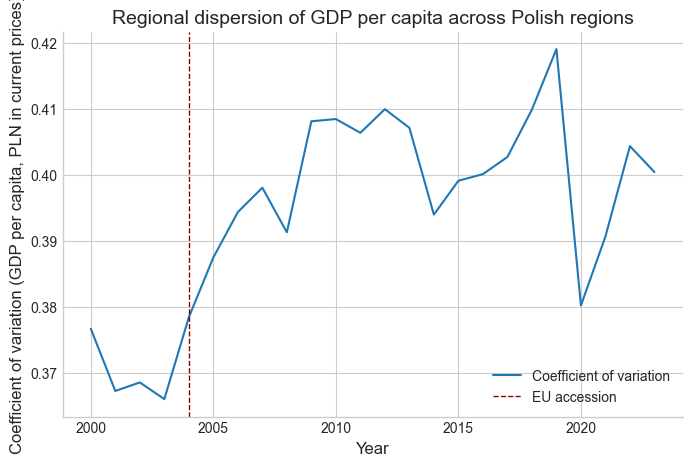

In [ ]:
plt.style.use("seaborn-v0_8-whitegrid")

plt.rcParams.update({
    "figure.figsize": (8, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

fig, ax = plt.subplots()

cv.plot(ax=ax, label="Coefficient of variation")

ax.axvline(
    2004,
    linestyle='--',
    color='darkred',
    linewidth=1,
    label='EU accession'
)

ax.set_ylabel("Coefficient of variation (GDP per capita, PLN in current prices)")
# ax.set_ylabel("Coefficient of variation (GDP per capita, Poland = 100)")

ax.set_xlabel("Year")
ax.set_title("Regional dispersion of GDP per capita across Polish regions")

ax.legend();


In [36]:
# merged[
#     merged['INDICATOR'] == 'produkt krajowy brutto na 1 mieszkańca, Polska = 100'
# ].groupby('YEAR')['VALUE'].std().plot();

### Gini - measure of inequality

In [56]:
import numpy as np

def gini(x):
    x = np.array(x, dtype=float)
    x = x[~np.isnan(x)]
    if len(x) == 0:
        return np.nan

    x = np.sort(x)
    n = len(x)
    mean_x = x.mean()

    return (
        np.sum((2 * np.arange(1, n + 1) - n - 1) * x)
        / (n * np.sum(x))
    )


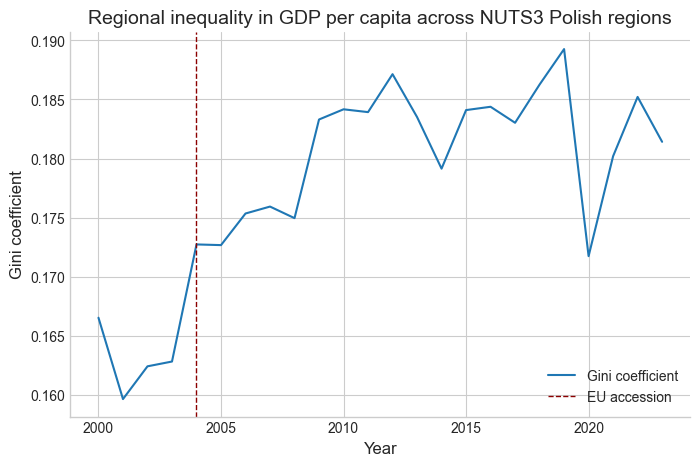

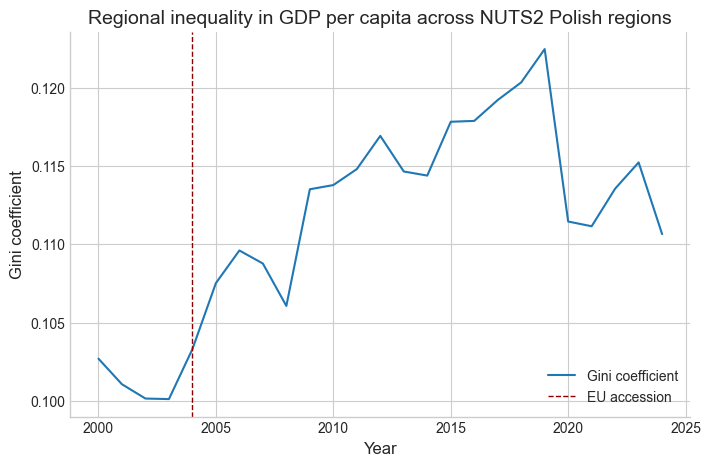

In [ ]:
for dataset in [merged, merged_nuts2]:

    fig, ax = plt.subplots()

    gini_by_year = (
    dataset[dataset['INDICATOR'] == 'produkt krajowy brutto na 1 mieszkańca']
    .groupby('YEAR')['VALUE']
    .apply(gini)).plot(ax=ax, label="Gini coefficient")

    ax.axvline(
        2004,
        linestyle='--',
        color='darkred',
        linewidth=1,
        label='EU accession'
    )

    ax.set_ylabel("Gini coefficient")
    # ax.set_ylabel("Coefficient of variation (GDP per capita, Poland = 100)")

    ax.set_xlabel("Year")
    if dataset is merged:
        ax.set_title("Regional inequality in GDP per capita across NUTS3 Polish regions")
    else:
        ax.set_title("Regional inequality in GDP per capita across NUTS2 Polish regions")

    ax.legend();
    if dataset is merged:
        fig.savefig('outputs/plots/lineplots/gini_coefficient_gdp_per_capita_nuts3.png', dpi=300)
    else:
        fig.savefig('outputs/plots/lineplots/gini_coefficient_gdp_per_capita_nuts2.png', dpi=300)

### Theil index - measure of inequality

In [59]:
def theil(x):
    x = np.array(x, dtype=float)
    x = x[~np.isnan(x)]
    if len(x) == 0:
        return np.nan

    mean_x = x.mean()
    x = x[x > 0]  # log-safe

    return np.mean((x / mean_x) * np.log(x / mean_x))

In [64]:
theil_by_year = (
    merged[merged['INDICATOR'] == 'produkt krajowy brutto na 1 mieszkańca']
    .groupby('YEAR')['VALUE']
    .apply(theil)
)

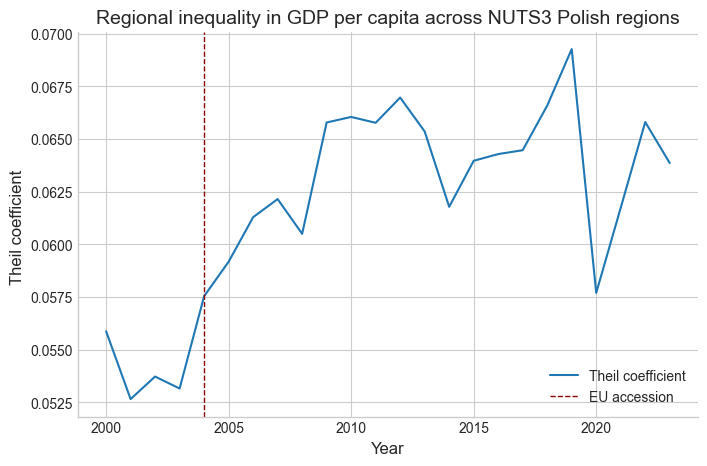

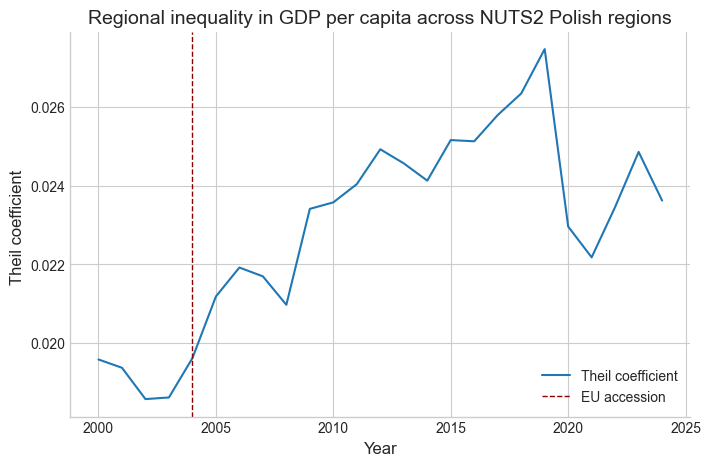

In [79]:
for dataset in [merged, merged_nuts2]:

    fig, ax = plt.subplots()

    theil_by_year = (
    dataset[dataset['INDICATOR'] == 'produkt krajowy brutto na 1 mieszkańca']
    .groupby('YEAR')['VALUE']
    .apply(theil)).plot(ax=ax, label="Theil coefficient")

    ax.axvline(
        2004,
        linestyle='--',
        color='darkred',
        linewidth=1,
        label='EU accession'
    )

    ax.set_ylabel("Theil coefficient ")
    # ax.set_ylabel("Coefficient of variation (GDP per capita, Poland = 100)")

    ax.set_xlabel("Year")
    
    if dataset is merged:
        ax.set_title("Regional inequality in GDP per capita across NUTS3 Polish regions")
    else:
        ax.set_title("Regional inequality in GDP per capita across NUTS2 Polish regions")

    ax.legend();

    if dataset is merged:
        fig.savefig('outputs/plots/lineplots/theil_index_gdp_per_capita_nuts3.png', dpi=300)
    else:
        fig.savefig('outputs/plots/lineplots/theil_index_gdp_per_capita_nuts2.png', dpi=300)

## MAPS

In [11]:
indicators_names_dict = {
    'produkt krajowy brutto na 1 mieszkańca': 'GDP per capita',
    'produkt krajowy brutto na 1 mieszkańca, Polska = 100': 'GDP per capita (Poland = 100%)',
    'produkt krajowy brutto na 1 mieszkańca, region=100': 'GDP per capita (NUTS2 region=100%)',
    'wskaźnik dyspersji PKB na 1 mieszkańca obliczony na poziomie podregionów dla Polski': 'GDP per capita dispersion (subregions for Poland)',
    'wskaźnik dyspersji PKB na 1 mieszkańca obliczony na poziomie podregionów dla poszczególnych regionów': 'GDP per capita dispersion (subregions for individual regions)'
}


cb_label = {
    'produkt krajowy brutto na 1 mieszkańca': 'PLN',
    'produkt krajowy brutto na 1 mieszkańca, Polska = 100': '%',
    'produkt krajowy brutto na 1 mieszkańca, region=100': '%'
}

### NUTS-3

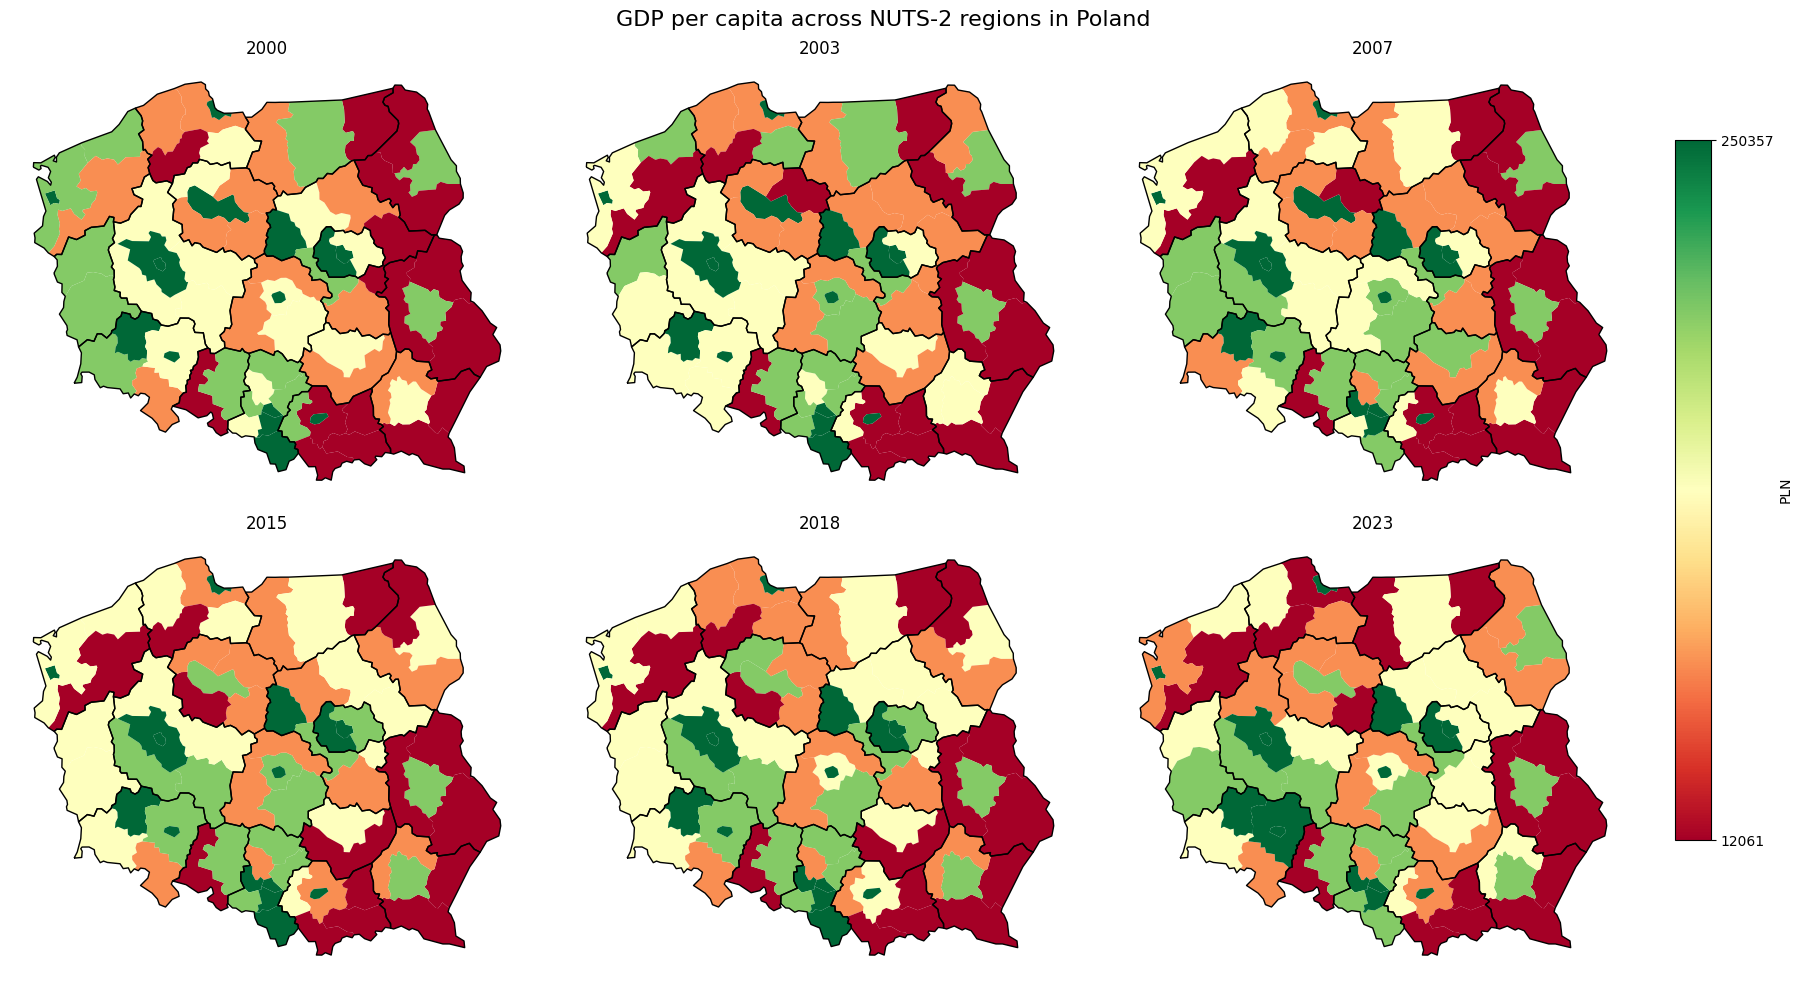

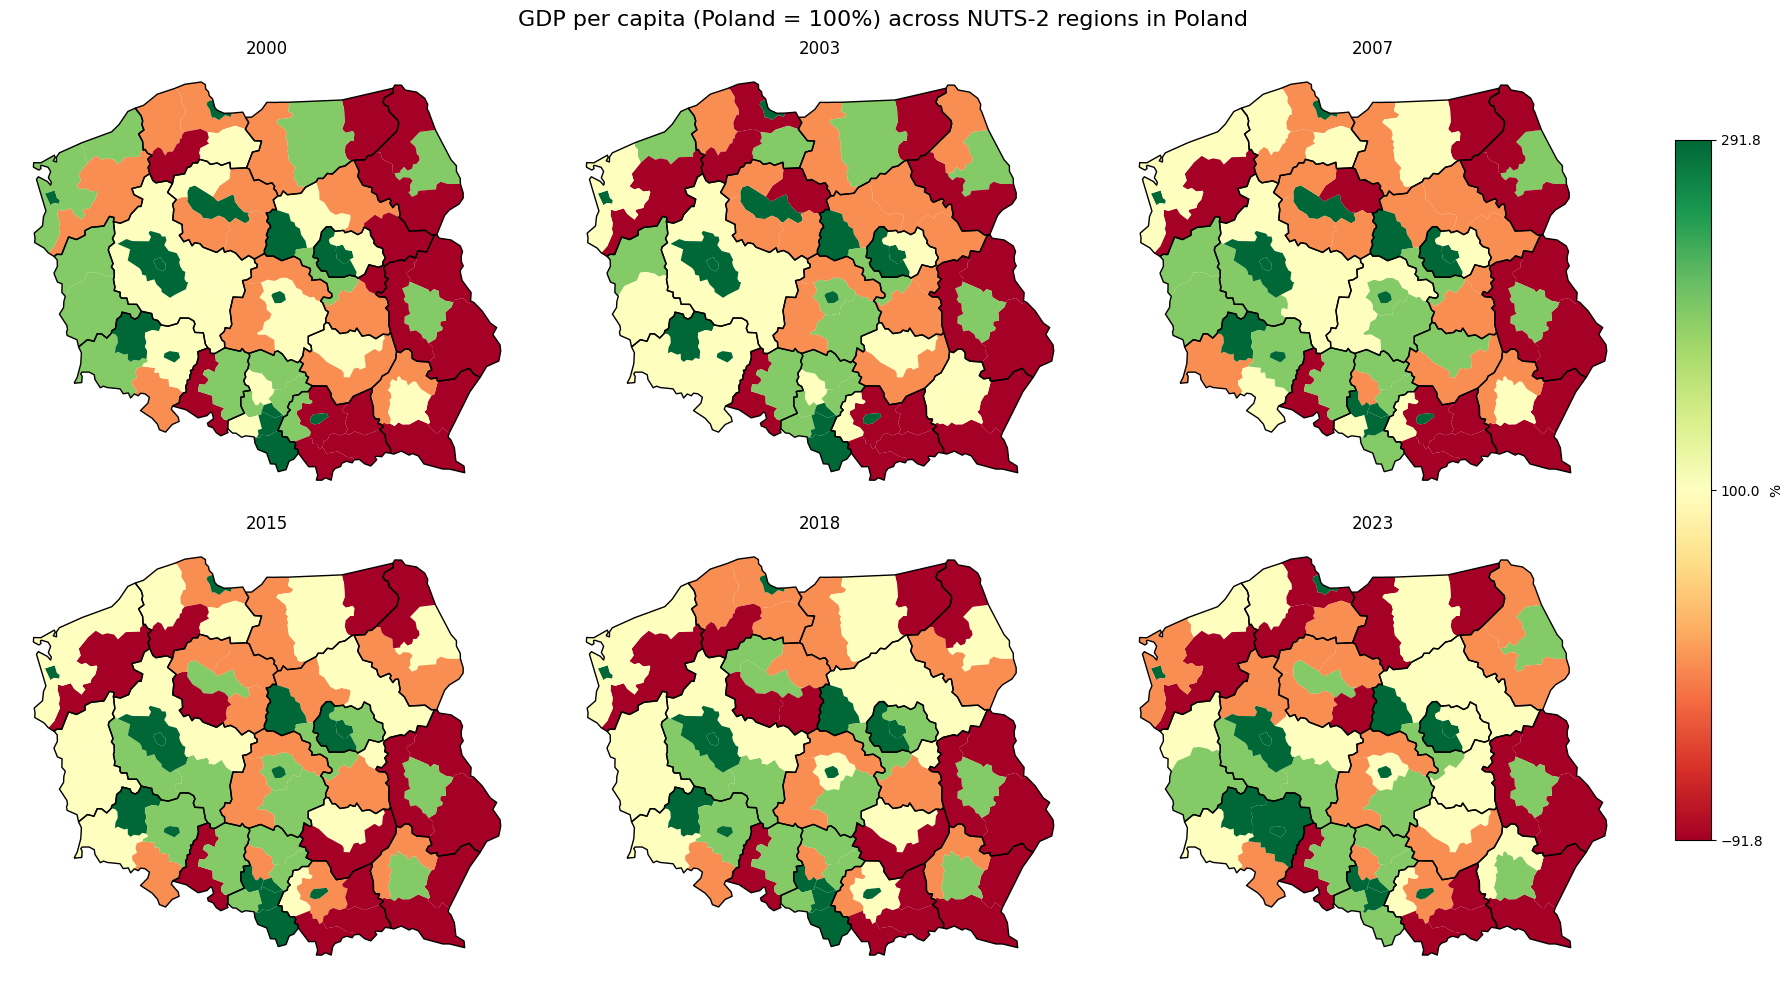

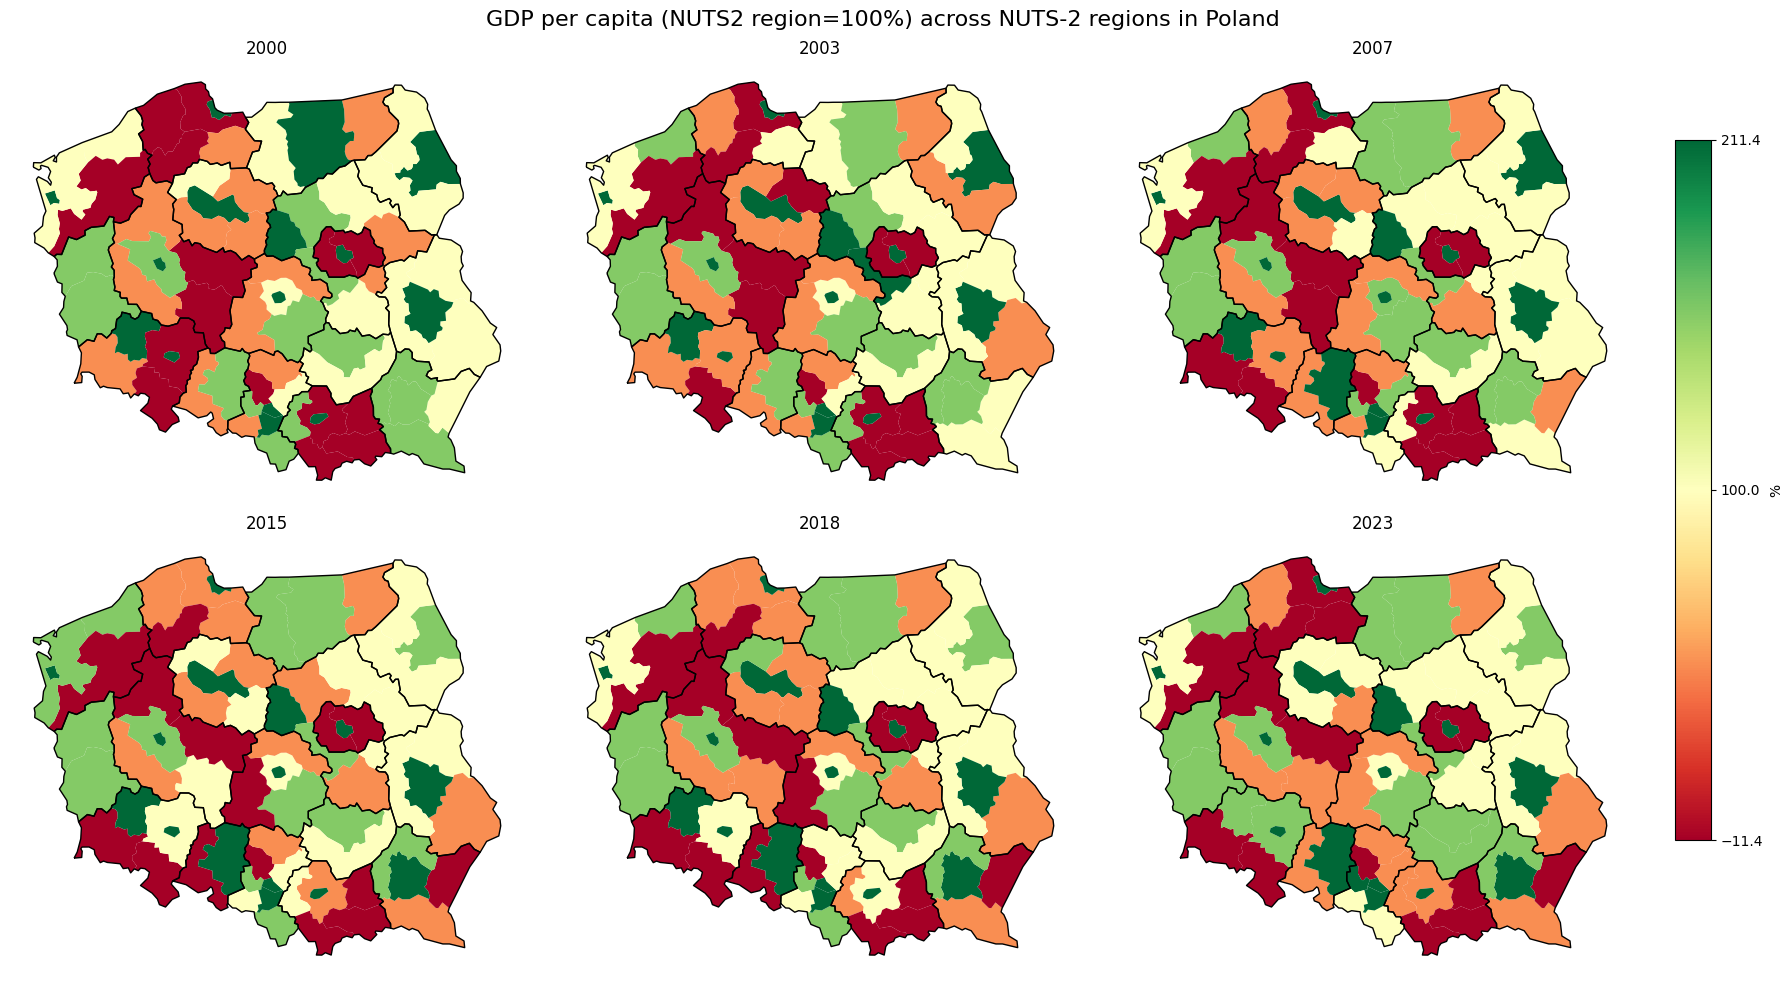

In [34]:
years = [2000, 2003, 2007, 2015, 2018, 2023]
indicators = [
    'produkt krajowy brutto na 1 mieszkańca',
    'produkt krajowy brutto na 1 mieszkańca, Polska = 100',
    'produkt krajowy brutto na 1 mieszkańca, region=100'
]

for indicator in indicators:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    vals = merged.loc[merged['INDICATOR'] == indicator, 'VALUE'].dropna()
    if '100' in indicator:  # for percentage indicators
        ref = 100
        max_abs = max(abs(vals.min() - ref), abs(vals.max() - ref))
        vmin, vmax = ref - max_abs, ref + max_abs
    else:  # for absolute value indicators
        vmin, vmax = vals.min(), vals.max()
        max_abs = max(abs(vmin), abs(vmax))
    
    for i, year in enumerate(years):
        ax = axes[i]
        data = merged[(merged['YEAR'] == year) & (merged['INDICATOR'] == indicator)]
        gdf = gpd.GeoDataFrame(data, geometry='geometry')
        gdf.plot(
            column='VALUE',
            ax=ax, 
            k=5, 
            scheme="Quantiles",
            cmap='RdYlGn',
            # vmin=vmin,
            # vmax=vmax,
            legend=False,
            missing_kwds={"color": "lightgrey"}
        )
        geom_nuts2.boundary.plot(ax=ax, color='black', linewidth=1)
        ax.set_title(f"{year}")
        ax.axis('off')

    plt.suptitle(f"{indicators_names_dict[indicator]} across NUTS-2 regions in Poland", fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.93, 1])
    cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
    sm = ScalarMappable(cmap='RdYlGn', norm=Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    fig.colorbar(sm, cax=cbar_ax, label=cb_label[indicator], ticks=[vmin, ref if '100' in indicator else 0, vmax])

    # plt.show()
    # plt.savefig(f'outputs/maps/poland/nuts-3/{indicators_names_dict[indicator]}_panel_map.png', dpi=300)
    # plt.close(fig)

### NUTS-2 maps

In [82]:
merged_nuts2.INDICATOR.unique()

array(['produkt krajowy brutto na 1 mieszkańca',
       'dynamika produktu krajowego brutto na 1 mieszkańca, rok poprzedni=100',
       'produkt krajowy brutto na 1 mieszkańca, Polska = 100',
       'wskaźnik dyspersji PKB na 1 mieszkańca obliczony na poziomie regionów dla Polski'],
      dtype=object)

In [13]:
years = [2000, 2003, 2007, 2015, 2018, 2023]
indicators = [
    'produkt krajowy brutto na 1 mieszkańca',
    'produkt krajowy brutto na 1 mieszkańca, Polska = 100']

for indicator in indicators:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    vals = merged_nuts2.loc[merged_nuts2['INDICATOR'] == indicator, 'VALUE'].dropna()
    if '100' in indicator:  # for percentage indicators
        ref = 100
        max_abs = max(abs(vals.min() - ref), abs(vals.max() - ref))
        vmin, vmax = ref - max_abs, ref + max_abs
    else:  # for absolute value indicators
        vmin, vmax = vals.min(), vals.max()
        max_abs = max(abs(vmin), abs(vmax))
    
    for i, year in enumerate(years):
        ax = axes[i]
        data = merged_nuts2[(merged_nuts2['YEAR'] == year) & (merged_nuts2['INDICATOR'] == indicator)]
        gdf = gpd.GeoDataFrame(data, geometry='geometry')
        gdf.plot(
            column='VALUE',
            ax=ax,
            cmap='RdYlGn',
            vmin=vmin,
            vmax=vmax,
            legend=False,
            missing_kwds={"color": "lightgrey"}
        )
        # geom_nuts2.boundary.plot(ax=ax, color='black', linewidth=1)
        ax.set_title(f"{year}")
        ax.axis('off')

    plt.suptitle(f"{indicators_names_dict[indicator]} across NUTS-2 regions in Poland", fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.93, 1])
    cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
    sm = ScalarMappable(cmap='RdYlGn', norm=Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    fig.colorbar(sm, cax=cbar_ax, label=cb_label[indicator], ticks=[vmin, ref if '100' in indicator else 0, vmax])

    plt.savefig(f'outputs/maps/poland/nuts-2/{indicator}_panel_map.png', dpi=300)
    plt.close(fig)